# Methods of Approximating Ambient Light Level Using Camera Output

## 1. Helper Functions

These helper functions can largely be ignored, but make sure to run each cell before using the algorithm section (Section 2).

### 1.1 Get Camera Capture

Get capture from camera.

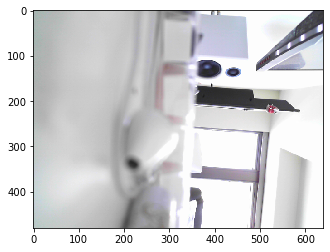

In [1]:
import matplotlib.pyplot as plt
import cv2

def show_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

def get_capture():
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

    # Lower resolution to speed up processing
    cap.set(3, 640)
    cap.set(4, 480)

    ret, img = cap.read()

    if not ret:
        print("Failed to get video capture.")
        raise ConnectionError
    else:
        return img

img = get_capture()
show_img(img)

### 1.2 Get Data Set

Load the camera frame to ALS lux reading into memory. The datasets are tuples where tuple[0] is the camera image and tuple[1] is the real lux value as read from the ALS.

In [2]:
import matplotlib.pyplot as plt
import glob
import cv2

DARK_SET_PATH = "dataset\dark_background"
LIGHT_D25_SET_PATH = "dataset\light_background_D25"
LIGHT_D90_SET_PATH = "dataset\light_background_D90"

def get_num_samples(set_path):
    return len(glob.glob1(set_path, "*.txt"))


def get_real_lux_samples(set_path):
    samples = []
    for i in range(get_num_samples(set_path)):
        with open("{}\{}.txt".format(set_path, i), "r") as f:
            file_str = f.read()
            samples.append(float(file_str))
    return samples

def get_camera_frames(set_path):
    samples = []
    for i in range(get_num_samples(set_path)):
        image = cv2.imread("{}\{}.png".format(set_path, i))
        samples.append(image)
    return samples

def get_dataset(set_path):
    return list(zip(get_camera_frames(set_path), get_real_lux_samples(set_path)))

dark_dataset = get_dataset(DARK_SET_PATH)
light_d25_dataset = get_dataset(LIGHT_D25_SET_PATH)
light_d90_dataset = get_dataset(LIGHT_D90_SET_PATH)

### 1.3 Map Operation

Does a map operation over a dataset. Usually the map operator is a function which takes in an image and then return the approximated lux level.

In [3]:
def map_data(dataset, map_op):
    def inner_map_op(data):
        img = data[0]
        real_lux = data[1]
        
        return map_op(img), real_lux
    
    return list(map(inner_map_op, dataset))

### 1.4 Plot Mapped Data

Takes in the mapped data (usually from the map_data() function) which is a list of tuples that contain tuple[0] is the approximated lux and tuple[1] is the real ALS data. The function then creates a scatter plot of the two data sets.

In [4]:
from pylab import plot, title, xlabel, ylabel, savefig, legend, array
from itertools import chain

def create_mapped_data_figure(title, mapped_data):
    approx_lux_list, real_lux_list = list(zip(*mapped_data))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    fig.suptitle(title)
    ax1.scatter(list(range(len(approx_lux_list))), approx_lux_list, c='r', marker="s", label='Approx Lux')
    ax1.scatter(list(range(len(real_lux_list))), real_lux_list, c='g', marker="s", label='Real Lux')
    ax1.set_ylabel("Lux")
    ax1.set_xlabel("Sample")

    plt.legend(loc='upper right', bbox_to_anchor=(1.32, 1));

### 1.5 Uber Mapping Function

Uber function which:
  1. Runs the lux estimation algorithm over each image in the loaded data set (where algo is f(img) -> lux).
  2. Maps each data set into a figure.
  3. Displays each mapping.
  
This is generally the function each algorithm should call to show its data.

In [5]:
def apply_and_show_algo(algo):
    light_d25_data_mapped = map_data(light_d25_dataset, get_avg_brightness)
    light_d90_data_mapped = map_data(light_d90_dataset, get_avg_brightness)
    dark_data_mapped = map_data(dark_dataset, get_avg_brightness)
    
    create_mapped_data_figure('Light Background D25 Light', light_d25_data_mapped)
    create_mapped_data_figure('Light Background D90 Light', light_d90_data_mapped)
    create_mapped_data_figure('Dark Background', dark_data_mapped)
    plt.show()

### 1.6 Get ALS Sample

Query the real lux value from the ALS sensor. There must be an ALS on the system, otherwise this function will throw.

In [6]:
import winrt.windows.devices.sensors as sensors

def get_als_sample():
    als = sensors.LightSensor.get_default()
    if not als:
        print("Can't read from ALS, none on system.")
        raise ConnectionError
    return als.get_current_reading().illuminance_in_lux

## 1.7 Live Comparison

Grabs a camera capture and runs the given lux estimation algorithm on it. The function will then query the ALS. The approx lux and real lux are returned as a tuple for comparison.

In [8]:
def live_compare(algo):
    img = get_capture()
    approx_lux = algo(img)
    real_lux = get_als_sample()
    return approx_lux, get_als_sample

## 2. (Option 1) Average Pixel Brightness

Convert the RGB image in YUV color space, then take the mean value from the Y channel.

In [10]:
import numpy as np

def get_avg_brightness(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(img_yuv)
    return np.mean(y)

### 2.1 Average Pixel Brightness Dataset Performance

Run the average pixel brightness algorithm over the datasets.

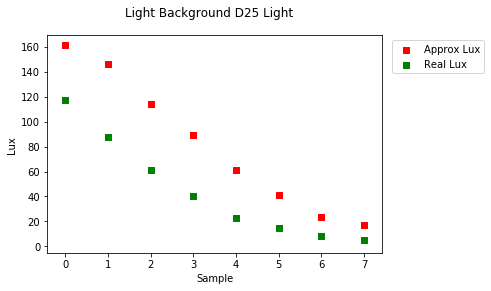

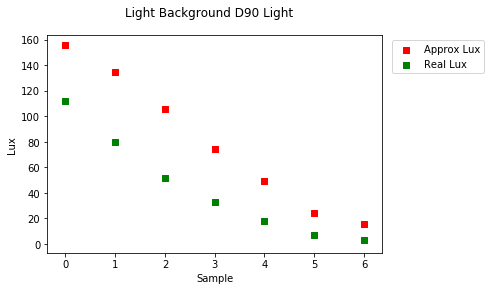

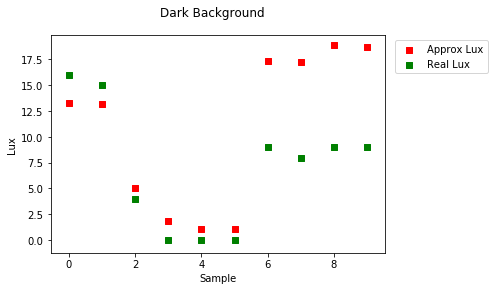

In [11]:
apply_and_show_algo(get_avg_brightness)

### 2.2 Average Pixel Brightness Live Sample

Run the average pixel brightness algorithm on a live camera sample.

In [12]:
approx_lux, real_lux = live_compare(get_avg_brightness)

print('Approx Lux: {}'.format(approx_lux))
print('Real Lux: {}'.format(real_lux))

Approx Lux: 201.2314453125
Real Lux: <function get_als_sample at 0x000002610612C168>


## 3. (Option 2) Use ML to Classify User Enviroment

Use ML to classify what brightness enviroment the camera image is in.

## 4. (Option 3) Linear Regression

Gather a lot of camera data and the associate lux readings from a real ALS. Then run regression on the data set to find a more accurate lux approximation. This can be used with Option 1 to "calibrate" the readings.